In [96]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import emcee
import seaborn as sns

In [97]:
filesuffix = "_prior_wp"
distance = [54, 105, 195, 305, 430] # Liepe bins: [54, 105, 195, 305, 430]; 2x bins: [54, 87.5, 122.5, 167.5, 222.5, 277.5, 332.5, 395]
time = [2.5,7.5,12.5,17.5,22.5]
time_labels = ["0-5","5-10","10-15","15-20","20-25"]
# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats

Attempting to load ../data/BP_inference/Single_wound_CTR_revision_prior_wp_bins00.h5
Attempting to load ../data/BP_inference/Single_wound_MCR_revision_prior_wp_bins00.h5
Attempting to load ../data/BP_inference/Single_wound_CTR_revision_prior_wp_bins10.h5
Attempting to load ../data/BP_inference/Single_wound_MCR_revision_prior_wp_bins10.h5
Attempting to load ../data/BP_inference/Single_wound_CTR_revision_prior_wp_bins20.h5
Attempting to load ../data/BP_inference/Single_wound_MCR_revision_prior_wp_bins20.h5
Attempting to load ../data/BP_inference/Single_wound_CTR_revision_prior_wp_bins30.h5
Attempting to load ../data/BP_inference/Single_wound_MCR_revision_prior_wp_bins30.h5
Attempting to load ../data/BP_inference/Single_wound_CTR_revision_prior_wp_bins40.h5
Attempting to load ../data/BP_inference/Single_wound_MCR_revision_prior_wp_bins40.h5
Attempting to load ../data/BP_inference/Single_wound_CTR_revision_prior_wp_bins01.h5
Attempting to load ../data/BP_inference/Single_wound_MCR_revision

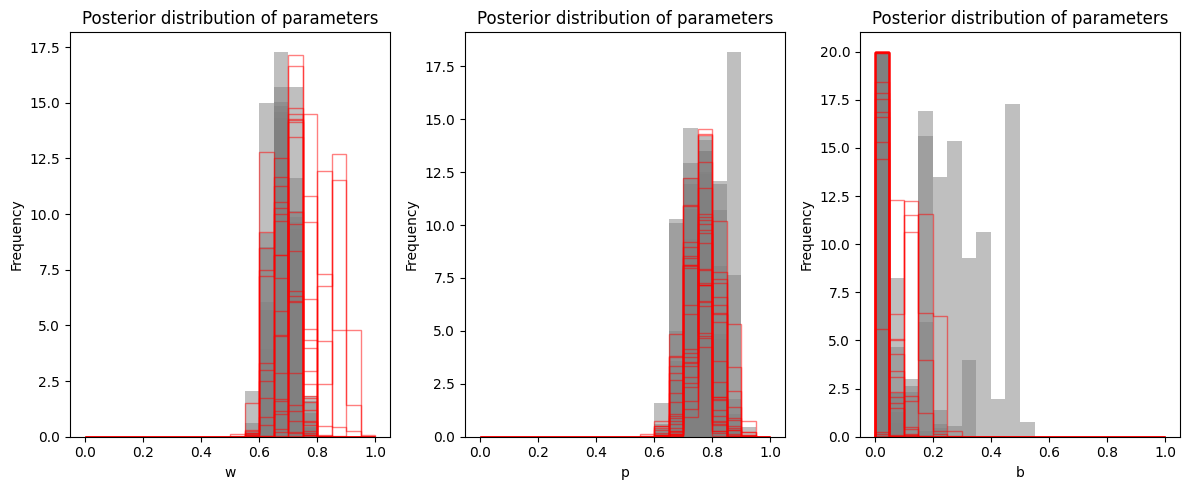

In [98]:
# calculate correlation times to estimate a burn-in and thin to use across all samples
# need to check for both CTR and MCR samples
stepSizeTimeBins = 1
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
max_tau = np.ones(3)
min_tau = np.inf*np.ones(3)

# make a plot to keep trap of overall distribution of paramters
plt.figure(figsize=(12,5))
labels = ['w','p','b']

for i in range(nTimeBins):
    for j in range(len(distance)):
        print('Attempting to load ' + '../data/BP_inference/Single_wound_CTR_revision'+filesuffix+'_bins{}{}.h5'.format(j,i))
        sample_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_CTR_revision'+filesuffix+'_bins{}{}.h5'.format(j,i))
        tau = sample_data.get_autocorr_time(tol=0)
        max_tau = np.max((max_tau, tau), axis=0)
        min_tau = np.min((min_tau, tau), axis=0)
        # now create plot
        this_thin = int(np.min(tau))
        this_burnin = max(3000,int(2 * np.max(tau)))
        samples = sample_data.get_chain(discard=this_burnin, thin=this_thin, flat=True)
        for dim in range(3):
            plt.subplot(1,3,dim+1)
            plt.hist(samples[:,dim], bins=20, range=(0, 1), density= True, alpha=0.5, color='grey')
            # sns.kdeplot(samples[:,dim], clip=[0, 1] ,color='grey')
            if i==nTimeBins-1 & j==len(distance)-1:
                plt.xlabel(labels[dim])
                plt.ylabel('Frequency')
                plt.title('Posterior distribution of parameters')
                plt.tight_layout()
        
        # now repeat for MCR samples
        print('Attempting to load ' + '../data/BP_inference/Single_wound_MCR_revision'+filesuffix+'_bins{}{}.h5'.format(j,i))
        sample_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_MCR_revision'+filesuffix+'_bins{}{}.h5'.format(j,i))
        tau = sample_data.get_autocorr_time(tol=0)
        max_tau = np.max((max_tau, tau), axis=0)
        min_tau = np.min((min_tau, tau), axis=0)
        # now create plot
        this_thin = int(np.min(tau))
        this_burnin = max(3000,int(2 * np.max(tau)))
        samples = sample_data.get_chain(discard=this_burnin, thin=this_thin, flat=True)
        for dim in range(3):
            plt.subplot(1,3,dim+1)
            plt.hist(samples[:,dim], bins=20, range=(0, 1), density= True, alpha=0.5, color='red', histtype='step')
            # sns.kdeplot(samples[:,dim], clip=[0, 1] ,color='grey')
            if i==nTimeBins-1 & j==len(distance)-1:
                plt.xlabel(labels[dim])
                plt.ylabel('Frequency')
                plt.title('Posterior distribution of parameters')
                plt.tight_layout()

burnin = max(3000,int(2 * np.max(max_tau)))
thin = int(np.min(min_tau))
print("highest auto-correlation time: {0}".format(max_tau))
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

plt.show()


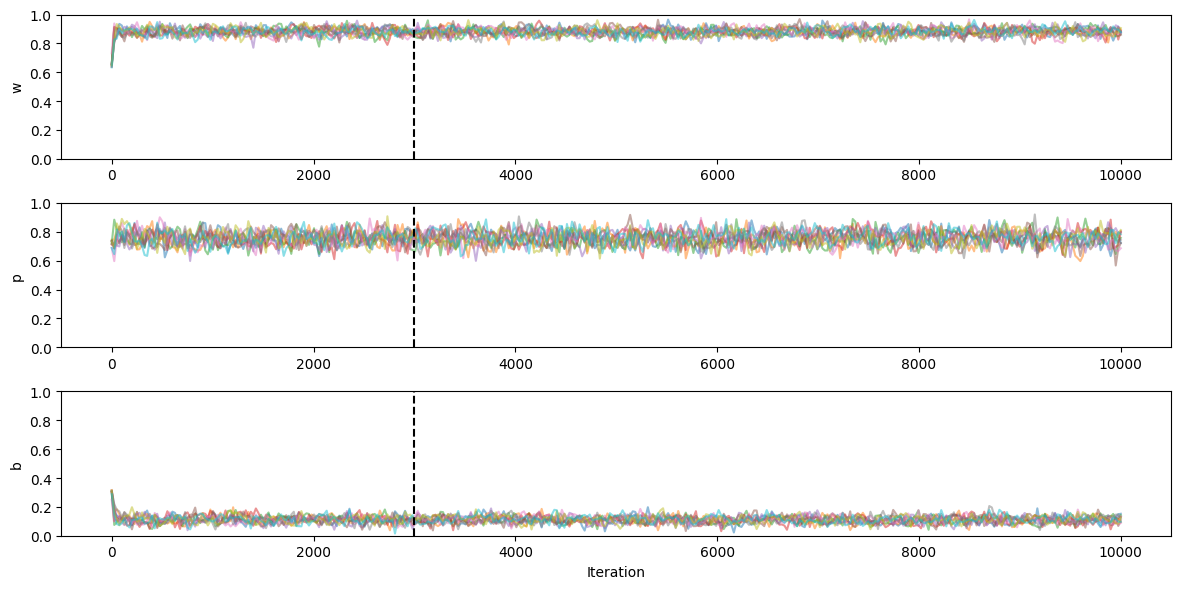

In [99]:
# plot some MCMC chains to check for a reasonable burn-in
sample_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_MCR_revision'+filesuffix+'_bins04.h5')
samples = sample_data.get_chain(discard=0, thin=thin, flat=False)

labels = ['w','p','b']
ndim = samples.shape[2]
n_walkers = samples.shape[1]
n_samples = samples.shape[0]
x_iterations = np.linspace(0, n_samples*thin, n_samples)

# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    plt.plot(x_iterations, samples[:, :, dim], alpha=0.5)
    plt.plot([burnin, burnin], [0, 1], 'k--')
    plt.ylabel(labels[dim])
    plt.ylim(0, 1)
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

In [100]:
# define functions to extract the observed bias values from the data
def bias_param_samples_from_file(emcee_samples):
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = emcee_samples.get_chain(discard=burnin, thin=thin, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    p = flattened_chain[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    observedBias = w * b  # The observed bias parameter from the walker posterior array
    observedPersistence = (1 - w) * p  # The observed persistence parameter from the walker posterior array
    mean_ob = np.mean(observedBias)
    std_ob = np.std(observedBias)
    mean_op = np.mean(observedPersistence)
    std_op = np.std(observedPersistence)
    return mean_ob, std_ob, mean_op, std_op

def bias_values_control(i, j): 
    control_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_CTR_revision'+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(control_data)

def bias_values_mcr(i, j): 
    mcr_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_MCR_revision'+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(mcr_data)

# def bias_values_halfwound_control(i, j): 
#     input_data_array = emcee.backends.HDFBackend('../data/BP_inference/Halfwound_control_bins{}{}.h5'.format(i,j))
#     return bias_param_samples_from_file(input_data_array)

# def bias_values_halfwound_mcr(i, j): 
#     input_data_array = emcee.backends.HDFBackend('../data/BP_inference/Halfwound_mcr_bins{}{}.h5'.format(i,j))
#     return bias_param_samples_from_file(input_data_array)

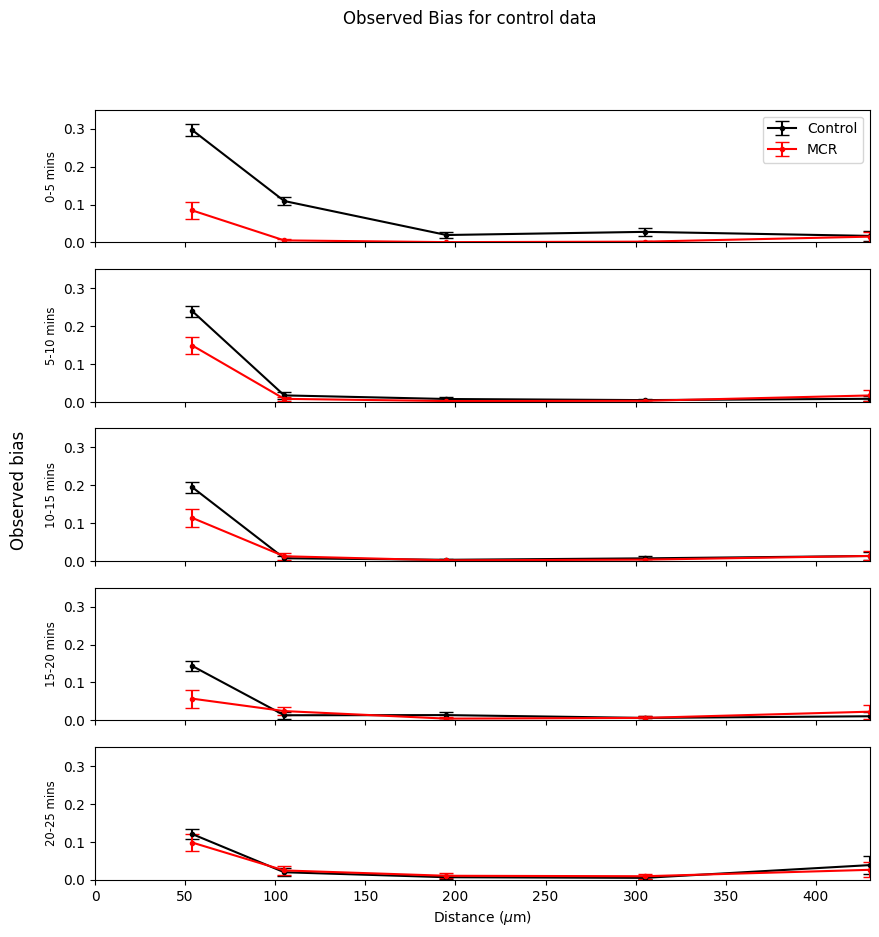

In [101]:
# plot observed bias for both conditions in one plot with a different panel for each time-point
stepSizeTimeBins = 1
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
fig, ax = plt.subplots(nTimeBins, 1, figsize=(10, 10), sharex=True)
fig.suptitle("Observed Bias for control data")
for i in range(nTimeBins):
    mean_ob_C = []
    std_ob_C = []
    meansM = []
    stdsM = []
    for j in range(len(distance)):
        ObBiasPersC = bias_values_control(j, i*stepSizeTimeBins)
        ObBiasM = bias_values_mcr(j, i*stepSizeTimeBins)

        mean_ob_C.append(ObBiasPersC[0])
        std_ob_C.append(ObBiasPersC[1])
        meansM.append(ObBiasM[0])
        stdsM.append(ObBiasM[1])
    ax[i].errorbar(distance,mean_ob_C,yerr = std_ob_C,marker='o',markersize = 3,capsize = 5,color = 'k', label = "Control")
    ax[i].errorbar(distance,meansM,yerr = stdsM,marker='o',markersize = 3,capsize = 5,color = 'r', label = "MCR")
    ax[i].set_ylim(0,0.35)
    ax[i].set_xlim(0,430)
    ax[i].set_ylabel(f"{time_labels[i*stepSizeTimeBins]} mins", rotation=90, size='small')
plt.xlabel("Distance ($\mu$m)")
ax[0].legend(loc='upper right')

fig.text(0.04, 0.5, 'Observed bias', va='center', rotation='vertical', size = 'large')
plt.savefig("Figures/Observed bias control & mcr_revision_data"+filesuffix+"bins.pdf")
plt.show()

In [102]:
def reshape_observed_params(bias_persistence_values):
    reshapedBias= []
    reshapedPersistence = []
    for i in range(len(time_labels)):
        meanObservedBias = []
        stdObservedBias = []
        meanObservedPersistence = []
        stdObservedPersistence = []
        for j in range(len(distance)):
            ObBiasPers = bias_persistence_values(j, i)
            meanObservedBias.append(ObBiasPers[0])
            stdObservedBias.append(ObBiasPers[1])
            meanObservedPersistence.append(ObBiasPers[2])
            stdObservedPersistence.append(ObBiasPers[3])
        reshapedBias.append([meanObservedBias,stdObservedBias])
        reshapedPersistence.append([meanObservedPersistence,stdObservedPersistence])
    return reshapedBias, reshapedPersistence

In [103]:
reshapedBias_control, reshapedPersistence_control = reshape_observed_params(bias_values_control)
reshapedBias_mcr, reshapedPersistence_mcr = reshape_observed_params(bias_values_mcr)
np.shape(reshapedBias_control) # dimensions are N time points, [mean, std], M distances

(5, 2, 5)

In [104]:
def plot_observed_params_all_timepoints(reshapedParams, yAxisLabel, saveFilename):
# plot observed param values for a given condition in one plot with a different line for each time-point
    xoffset = 0#1.0
    xoffsetstart = 0# -len(time_labels)/stepSizeTimeBins/2*xoffset
    for i in range(0,len(time_labels)-1,stepSizeTimeBins):
        plt.errorbar(np.array(distance)+xoffsetstart+i*xoffset, reshapedParams[i][0], 
                     yerr=reshapedParams[i][1],marker='o',markersize = 3,capsize = 5, label = f"{time_labels[i]} mins")
    plt.legend()
    plt.ylim(0,0.35)
    plt.xlim(0,430)
    plt.xlabel("distance ($\mu$m)")
    plt.ylabel(yAxisLabel)
    plt.savefig(saveFilename)
    plt.show()

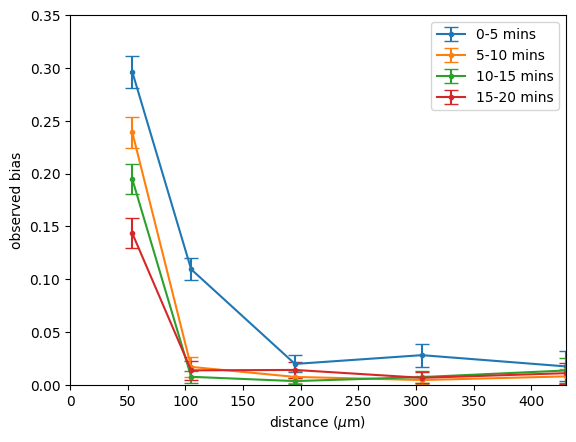

In [105]:
plot_observed_params_all_timepoints(reshapedBias_control, "observed bias", "Figures/Observed_bias_control_revision"+filesuffix+".pdf")

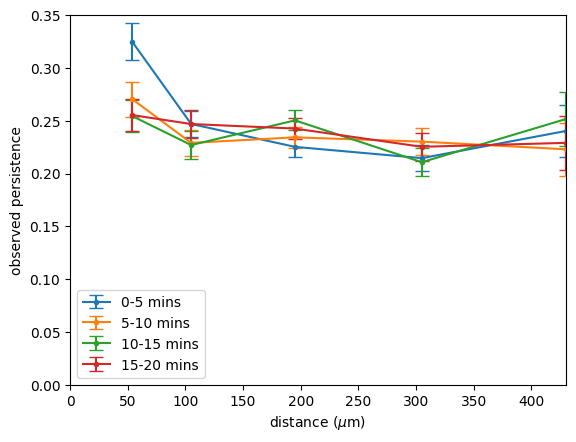

In [106]:
plot_observed_params_all_timepoints(reshapedPersistence_control, "observed persistence", "Figures/Observed_persistence_control_revision"+filesuffix+".pdf")

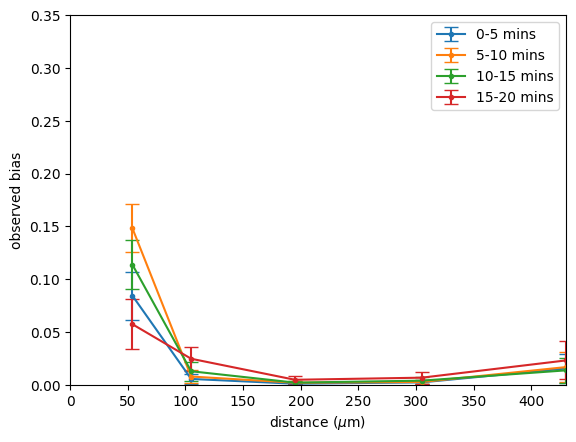

In [107]:
# plot observed bias for MCR condition in one plot with a different line for each time-point
plot_observed_params_all_timepoints(reshapedBias_mcr, "observed bias", "Figures/Observed_bias_mcr_revision"+filesuffix+".pdf")

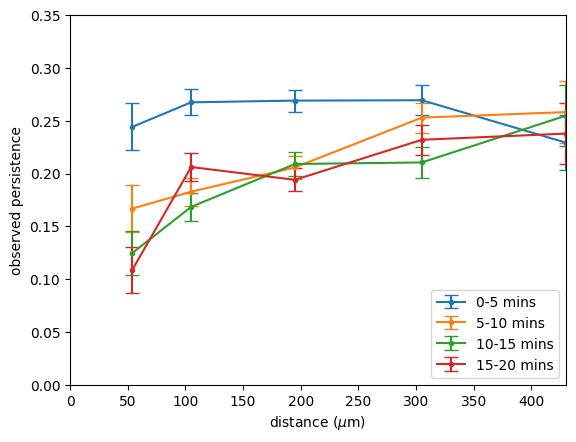

In [108]:
plot_observed_params_all_timepoints(reshapedPersistence_mcr, "observed persistence", "Figures/Observed_persistence_mcr_revision"+filesuffix+".pdf")

In [23]:
# # now plot observed bias for half-wound data on either side of wound at 10 and 20 min bins
# # rearrange data to plot all time-points in one plot
# obs_bias_halfwound_control = []
# for i in range(len(time_labels)):
#     meansC = []
#     stdsC = []
#     for j in range(len(distance)):
#         ObBiasC = bias_values_halfwound_control(j, i)
#         meansC.append(ObBiasC[0])
#         stdsC.append(ObBiasC[1])
#     obs_bias_halfwound_control.append([meansC,stdsC])
# np.shape(obs_bias_halfwound_control) # dimensions are 8 time points, [mean, std], 7 distances

In [24]:
# obs_bias_halfwound_mcr = []
# for i in range(len(time_labels)):
#     meansM = []
#     stdsM = []
#     for j in range(len(distance)):
#         ObBiasM = bias_values_halfwound_mcr(j, i)
#         meansM.append(ObBiasM[0])
#         stdsM.append(ObBiasM[1])
#     obs_bias_halfwound_mcr.append([meansM,stdsM])
# np.shape(obs_bias_halfwound_mcr)# dimensions are 8 time points, [mean, std], 7 distances

In [25]:
# ax = plt.gca()
# # for i in range(0,len(time_labels),stepSizeTimeBins):
# for i in [3,7]:
#     color = next(ax._get_lines.prop_cycler)['color']
#     plt.errorbar(np.array(distance)+xoffsetstart+i*xoffset, 
#                  obs_bias_halfwound_control[i][0], 
#                  yerr=obs_bias_halfwound_control[i][1],marker='o',markersize = 3,capsize = 5, color=color, label = f"{time_labels[i]} mins")
#     plt.errorbar(-np.array(distance)+xoffsetstart+i*xoffset, 
#                 obs_bias_halfwound_mcr[i][0], 
#                 yerr=obs_bias_halfwound_mcr[i][1],marker='o',markersize = 3,capsize = 5, color=color)
    
# plt.legend()
# plt.ylim(0,0.7)
# plt.xlim(-110,110)
# plt.xlabel("distance ($\mu$m)")
# plt.ylabel("observed bias")
# plt.savefig("Figures/Observed_bias_halfwound.pdf")

# plt.show()